# Introduction
(VAE) https://arxiv.org/abs/1312.6114
Variational Autoencoder

From the abstract:

"We introduce a stochastic variational inference and learning algorithm that
scales to large datasets and, under some mild differentiability conditions,
even works in the intractable case. Our contributions is two-fold. First, we
show that a reparameterization of the variational lower bound yields a lower
bound estimator that can be straightforwardly optimized using standard
stochastic gradient methods. Second, we show that for i.i.d. datasets with
continuous latent variables per datapoint, posterior inference can be made
especially efficient by fitting an approximate inference model (also called a
recognition model) to the intractable posterior using the proposed lower bound
estimator."

Basically VAEs encode an input into a given dimension z, reparametrize that z
using it's mean and std, and then reconstruct the image from reparametrized z.
This lets us tractably model latent representations that we may not be
explicitly aware of that are in the data. For a simple example of what this may
look like, read up on "Karl Pearson's Crabs." The basic idea was that a
scientist collected data on a population of crabs, noticed that the distribution
was non-normal, and Pearson postulated it was because there were likely more
than one population of crabs studied. This would've been a latent variable,
since the data colllector did not initially know or perhaps even suspect this.
# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image 


import numpy as np
from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
batch_size = 128
num_epoch = 100

lr = 1e-4 # leanring rate of Encoder and Decoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../img'):
    os.mkdir('../img')

# Transform of our datasets
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])
    
# MNIST datasets downloading……
mnist = datasets.MNIST(
    root = '../data/mnist/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = mnist, batch_size = batch_size, shuffle = True
)

In [4]:
def to_gray_img(x):
    out = 0.5*(x+1)
    out = out.clamp(0,1) # force therandom distribution of x into [min, max]
    out = out.view(-1, 1, 28, 28) # view a multi-row Tensor as one row
    return out

# Model Definitions
## Encoder
Input of Encoder is an image, output is encoded
    vector representation of that image.
    
As to MLP encoder for VAE. Input is an image,
outputs are the mean, std of the latent variable z pre-reparametrization

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.En = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
        )
        self.mu = nn.Linear(256, 8)
        self.log_var = nn.Linear(256,8)
    
    def forward(self, x):
        x = self.En(x)
        mu, log_var = self.mu(x), self.log_var(x)
        return mu, log_var

## Decoder
Input is an encoded vector representation, output is reconstructed image.

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.De = nn.Sequential(
            nn.Linear(8, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 784),
        )
    
    def forward(self, x):
        x = self.De(x)
        return x

## Variational AutoEncoder
VAE super class to reconstruct an image. Contains reparametrization
    method for latent variable z

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # self.__dict__.update(locals())
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick: z = mean + std*epsilon,
        where epsilon ~ N(0, 1).
        """
        epsilon = torch.randn(mu.shape).to(device)
        z = mu + epsilon * torch.exp(log_var/2).to(device) # 2 for convert var to std
        return z
    

#  Traning Phase
## Model & Opitmizer

In [8]:
VAE = VAE()
AE = VAE.to(device)

In [9]:

optimizer = torch.optim.Adam(params = [p for p in AE.parameters()
                                      if p.requires_grad],
                             lr = lr
                            )

## Trainning Start!

### WTF is KL divergence loss?
The KL divergence tells us how well the probability distribution $Q$ approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another.

In VAE, let X be the data we want to model, z be latent variable, $P(X)$ be the probability distribution of data, $P(z)$ be the probability distribution of the latent variable and $P(X|z)$ be the distribution of generating data given latent variable

In the case of variational autoencoders, our objective is to infer $P(z)$ from $P(z|X)$. $P(z|X)$ is the probability distribution that projects our data into latent space. But since we do not have the distribution $P(z|X)$, we estimate it using its simpler estimation $Q$.

Now while training our VAE, the encoder should try to learn the simpler distribution $Q(z|X)$ such that it is as close as possible to the actual distribution $P(z|X)$. This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.
$$D_{KL}[Q(z|X)||P(z|X)]=E[logQ(z|X)−logP(z|X)]$$

In [10]:
def KL_Divergence(mu, log_var):
    """ Compute Kullback-Leibler divergence """
    return torch.sum(0.5 * (mu ** 2 + torch.exp(log_var) - log_var -1))

  0%|          | 0/100 [00:00<?, ?it/s]

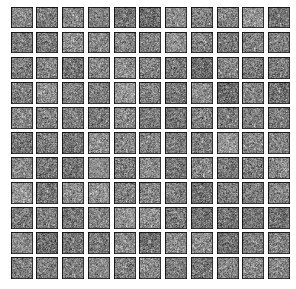

Epoch[0/100],recon_loss:22247.615234, kl_loss:2316.442627


  1%|          | 1/100 [00:58<1:35:42, 58.01s/it]

Epoch[1/100],recon_loss:16231.881836, kl_loss:2108.312988


  2%|▏         | 2/100 [01:46<1:30:00, 55.11s/it]

Epoch[2/100],recon_loss:15340.405273, kl_loss:2059.089355


  3%|▎         | 3/100 [02:24<1:20:38, 49.88s/it]

Epoch[3/100],recon_loss:14766.486328, kl_loss:2068.072266


  4%|▍         | 4/100 [03:14<1:19:55, 49.95s/it]

Epoch[4/100],recon_loss:13365.369141, kl_loss:2055.001221


  5%|▌         | 5/100 [03:53<1:13:51, 46.65s/it]

Epoch[5/100],recon_loss:12949.445312, kl_loss:2044.105957


  6%|▌         | 6/100 [04:38<1:12:24, 46.22s/it]

Epoch[6/100],recon_loss:12640.004883, kl_loss:1986.236694


  7%|▋         | 7/100 [05:18<1:08:51, 44.43s/it]

Epoch[7/100],recon_loss:12301.722656, kl_loss:1925.881592


  8%|▊         | 8/100 [05:59<1:06:25, 43.32s/it]

Epoch[8/100],recon_loss:12485.968750, kl_loss:1937.595703


  9%|▉         | 9/100 [06:44<1:06:34, 43.90s/it]

Epoch[9/100],recon_loss:12245.660156, kl_loss:1900.837402


 10%|█         | 10/100 [07:18<1:01:26, 40.96s/it]

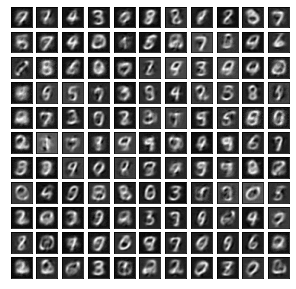

Epoch[10/100],recon_loss:11849.036133, kl_loss:1885.209229


 11%|█         | 11/100 [08:19<1:09:42, 46.99s/it]

Epoch[11/100],recon_loss:12302.607422, kl_loss:1889.923706


 12%|█▏        | 12/100 [09:00<1:05:58, 44.98s/it]

Epoch[12/100],recon_loss:12130.327148, kl_loss:1855.229736


 13%|█▎        | 13/100 [09:40<1:03:27, 43.76s/it]

Epoch[13/100],recon_loss:11632.976562, kl_loss:1927.000000


 14%|█▍        | 14/100 [10:19<1:00:39, 42.32s/it]

Epoch[14/100],recon_loss:11874.068359, kl_loss:1896.109497


 15%|█▌        | 15/100 [11:01<59:36, 42.07s/it]  

Epoch[15/100],recon_loss:11477.566406, kl_loss:1903.705688


 16%|█▌        | 16/100 [11:38<56:40, 40.48s/it]

Epoch[16/100],recon_loss:11020.210938, kl_loss:1875.898193


 17%|█▋        | 17/100 [12:25<59:02, 42.68s/it]

Epoch[17/100],recon_loss:11330.613281, kl_loss:1874.958984


 18%|█▊        | 18/100 [13:06<57:16, 41.90s/it]

Epoch[18/100],recon_loss:12687.378906, kl_loss:1902.288452


 19%|█▉        | 19/100 [13:55<59:48, 44.30s/it]

Epoch[19/100],recon_loss:11065.695312, kl_loss:1910.454346


 20%|██        | 20/100 [14:33<56:12, 42.16s/it]

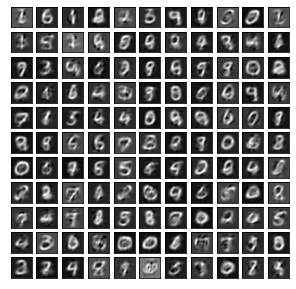

Epoch[20/100],recon_loss:10942.567383, kl_loss:1909.590210


 21%|██        | 21/100 [15:30<1:01:24, 46.63s/it]

Epoch[21/100],recon_loss:10647.890625, kl_loss:1918.159424


 22%|██▏       | 22/100 [16:16<1:00:23, 46.46s/it]

Epoch[22/100],recon_loss:11414.040039, kl_loss:1959.546875


 23%|██▎       | 23/100 [17:08<1:01:57, 48.28s/it]

Epoch[23/100],recon_loss:10915.978516, kl_loss:1982.926758


 24%|██▍       | 24/100 [17:50<58:50, 46.45s/it]  

Epoch[24/100],recon_loss:10868.783203, kl_loss:1956.009644


 25%|██▌       | 25/100 [18:36<57:35, 46.07s/it]

Epoch[25/100],recon_loss:11141.389648, kl_loss:1964.159668


 26%|██▌       | 26/100 [19:22<57:00, 46.22s/it]

Epoch[26/100],recon_loss:10425.365234, kl_loss:1995.347412


 27%|██▋       | 27/100 [20:08<55:55, 45.97s/it]

Epoch[27/100],recon_loss:11456.578125, kl_loss:1988.979736


 28%|██▊       | 28/100 [20:53<54:53, 45.74s/it]

Epoch[28/100],recon_loss:10613.097656, kl_loss:1943.426270


 29%|██▉       | 29/100 [21:36<53:03, 44.84s/it]

Epoch[29/100],recon_loss:10812.493164, kl_loss:1968.809448


 30%|███       | 30/100 [22:21<52:30, 45.01s/it]

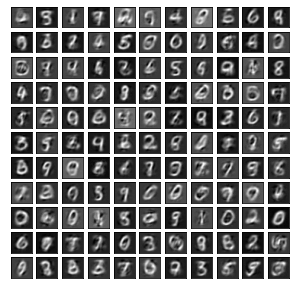

Epoch[30/100],recon_loss:11144.536133, kl_loss:1968.028320


 31%|███       | 31/100 [23:29<59:52, 52.06s/it]

Epoch[31/100],recon_loss:10852.539062, kl_loss:1958.543701


 32%|███▏      | 32/100 [24:14<56:27, 49.81s/it]

Epoch[32/100],recon_loss:10711.597656, kl_loss:1944.160156


 33%|███▎      | 33/100 [25:07<56:42, 50.78s/it]

Epoch[33/100],recon_loss:11528.861328, kl_loss:1962.282471


 34%|███▍      | 34/100 [25:44<51:10, 46.52s/it]

Epoch[34/100],recon_loss:10620.457031, kl_loss:1978.072266


 35%|███▌      | 35/100 [26:38<52:58, 48.90s/it]

Epoch[35/100],recon_loss:11035.279297, kl_loss:1978.621338


 36%|███▌      | 36/100 [27:17<48:56, 45.88s/it]

Epoch[36/100],recon_loss:9914.945312, kl_loss:1982.356445


 37%|███▋      | 37/100 [28:12<50:57, 48.53s/it]

Epoch[37/100],recon_loss:10557.571289, kl_loss:2052.137695


 38%|███▊      | 38/100 [28:49<46:41, 45.19s/it]

Epoch[38/100],recon_loss:10787.562500, kl_loss:1992.033325


 39%|███▉      | 39/100 [29:44<48:52, 48.08s/it]

Epoch[39/100],recon_loss:11031.474609, kl_loss:2035.892334


 40%|████      | 40/100 [30:17<43:33, 43.55s/it]

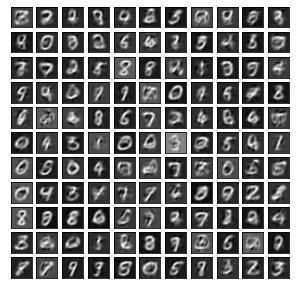

Epoch[40/100],recon_loss:10583.001953, kl_loss:2043.940918


 41%|████      | 41/100 [31:17<47:52, 48.69s/it]

Epoch[41/100],recon_loss:10018.486328, kl_loss:2059.431885


 42%|████▏     | 42/100 [31:58<44:32, 46.08s/it]

Epoch[42/100],recon_loss:10610.803711, kl_loss:2014.569458


 43%|████▎     | 43/100 [32:48<45:00, 47.37s/it]

Epoch[43/100],recon_loss:10705.391602, kl_loss:2017.795410


 44%|████▍     | 44/100 [33:26<41:34, 44.55s/it]

Epoch[44/100],recon_loss:10689.697266, kl_loss:2025.650269


 45%|████▌     | 45/100 [34:19<43:14, 47.18s/it]

Epoch[45/100],recon_loss:9935.550781, kl_loss:1981.195557


 46%|████▌     | 46/100 [34:53<38:56, 43.27s/it]

Epoch[46/100],recon_loss:10406.308594, kl_loss:1997.871094


 47%|████▋     | 47/100 [35:41<39:19, 44.52s/it]

Epoch[47/100],recon_loss:10487.795898, kl_loss:2032.265503


 48%|████▊     | 48/100 [36:17<36:23, 41.98s/it]

Epoch[48/100],recon_loss:10703.718750, kl_loss:2051.696533


 49%|████▉     | 49/100 [37:10<38:39, 45.49s/it]

Epoch[49/100],recon_loss:10730.330078, kl_loss:1973.972656


 50%|█████     | 50/100 [37:45<35:11, 42.23s/it]

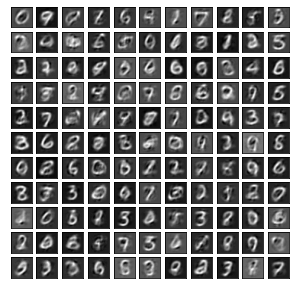

Epoch[50/100],recon_loss:10415.070312, kl_loss:2015.215210


 51%|█████     | 51/100 [38:49<39:48, 48.74s/it]

Epoch[51/100],recon_loss:10699.339844, kl_loss:2023.392090


 52%|█████▏    | 52/100 [39:30<37:07, 46.41s/it]

Epoch[52/100],recon_loss:10375.294922, kl_loss:2038.263062


 53%|█████▎    | 53/100 [40:21<37:19, 47.65s/it]

Epoch[53/100],recon_loss:10464.951172, kl_loss:2075.892090


 54%|█████▍    | 54/100 [41:12<37:23, 48.77s/it]

Epoch[54/100],recon_loss:10367.875000, kl_loss:1995.037109


 55%|█████▌    | 55/100 [42:04<37:13, 49.64s/it]

Epoch[55/100],recon_loss:10264.077148, kl_loss:2054.046875


 56%|█████▌    | 56/100 [42:54<36:36, 49.91s/it]

Epoch[56/100],recon_loss:9975.453125, kl_loss:2068.932861


 57%|█████▋    | 57/100 [43:42<35:20, 49.32s/it]

Epoch[57/100],recon_loss:10253.654297, kl_loss:2050.940430


 58%|█████▊    | 58/100 [44:30<34:09, 48.81s/it]

Epoch[58/100],recon_loss:9551.240234, kl_loss:2055.925537


 59%|█████▉    | 59/100 [45:20<33:42, 49.33s/it]

Epoch[59/100],recon_loss:10432.727539, kl_loss:2011.341553


 60%|██████    | 60/100 [46:08<32:40, 49.00s/it]

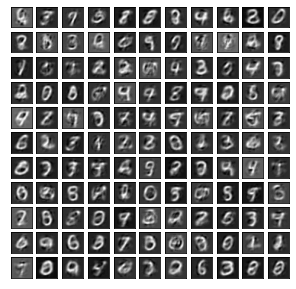

Epoch[60/100],recon_loss:10442.607422, kl_loss:2048.315918


 61%|██████    | 61/100 [47:23<36:51, 56.70s/it]

Epoch[61/100],recon_loss:10482.664062, kl_loss:2055.817383


 62%|██████▏   | 62/100 [48:14<34:48, 54.97s/it]

Epoch[62/100],recon_loss:9983.307617, kl_loss:2027.412598


 63%|██████▎   | 63/100 [48:55<31:13, 50.64s/it]

Epoch[63/100],recon_loss:9306.536133, kl_loss:2049.401611


 64%|██████▍   | 64/100 [49:38<29:06, 48.51s/it]

Epoch[64/100],recon_loss:10073.104492, kl_loss:2035.603638


 65%|██████▌   | 65/100 [50:26<28:10, 48.29s/it]

Epoch[65/100],recon_loss:9439.129883, kl_loss:2080.246094


 66%|██████▌   | 66/100 [51:23<28:52, 50.95s/it]

Epoch[66/100],recon_loss:9784.986328, kl_loss:2096.164307


 67%|██████▋   | 67/100 [52:08<27:01, 49.13s/it]

Epoch[67/100],recon_loss:10120.236328, kl_loss:2070.723633


 68%|██████▊   | 68/100 [52:57<26:11, 49.09s/it]

Epoch[68/100],recon_loss:10002.134766, kl_loss:2029.654419


 69%|██████▉   | 69/100 [53:44<25:04, 48.52s/it]

Epoch[69/100],recon_loss:9195.996094, kl_loss:2071.994629


 70%|███████   | 70/100 [54:34<24:29, 48.98s/it]

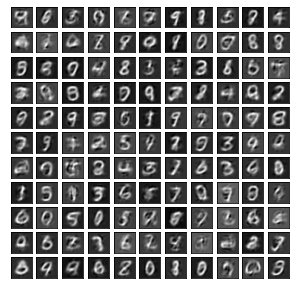

Epoch[70/100],recon_loss:9597.238281, kl_loss:2076.066406


 71%|███████   | 71/100 [55:34<25:17, 52.32s/it]

Epoch[71/100],recon_loss:9739.801758, kl_loss:2090.261230


 72%|███████▏  | 72/100 [56:28<24:38, 52.80s/it]

Epoch[72/100],recon_loss:10420.600586, kl_loss:2103.085449


 73%|███████▎  | 73/100 [57:11<22:20, 49.66s/it]

Epoch[73/100],recon_loss:10397.107422, kl_loss:2069.912109


 74%|███████▍  | 74/100 [58:02<21:41, 50.06s/it]

Epoch[74/100],recon_loss:8438.978516, kl_loss:2031.831177


 75%|███████▌  | 75/100 [58:38<19:09, 46.00s/it]

Epoch[75/100],recon_loss:9416.564453, kl_loss:2075.460693


 76%|███████▌  | 76/100 [59:25<18:31, 46.32s/it]

Epoch[76/100],recon_loss:10132.583008, kl_loss:2116.083496


 77%|███████▋  | 77/100 [1:00:02<16:38, 43.43s/it]

Epoch[77/100],recon_loss:9897.320312, kl_loss:2050.816406


 78%|███████▊  | 78/100 [1:00:52<16:41, 45.53s/it]

Epoch[78/100],recon_loss:10128.576172, kl_loss:2038.705200


 79%|███████▉  | 79/100 [1:01:31<15:14, 43.54s/it]

Epoch[79/100],recon_loss:9778.507812, kl_loss:2071.445312


 80%|████████  | 80/100 [1:02:23<15:21, 46.08s/it]

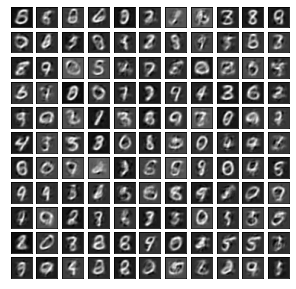

Epoch[80/100],recon_loss:10407.097656, kl_loss:2065.842285


 81%|████████  | 81/100 [1:03:17<15:22, 48.53s/it]

Epoch[81/100],recon_loss:10244.298828, kl_loss:2069.754883


 82%|████████▏ | 82/100 [1:04:05<14:27, 48.21s/it]

Epoch[82/100],recon_loss:9675.667969, kl_loss:2059.986816


 83%|████████▎ | 83/100 [1:04:46<13:01, 45.96s/it]

Epoch[83/100],recon_loss:9341.645508, kl_loss:2049.505371


 84%|████████▍ | 84/100 [1:05:28<11:59, 44.98s/it]

Epoch[84/100],recon_loss:9738.398438, kl_loss:2086.425049


 85%|████████▌ | 85/100 [1:06:08<10:49, 43.32s/it]

Epoch[85/100],recon_loss:9985.000000, kl_loss:2052.510986


 86%|████████▌ | 86/100 [1:06:50<10:01, 42.98s/it]

Epoch[86/100],recon_loss:9528.681641, kl_loss:2132.891357


 87%|████████▋ | 87/100 [1:07:36<09:32, 44.04s/it]

Epoch[87/100],recon_loss:9366.217773, kl_loss:2096.118652


 88%|████████▊ | 88/100 [1:08:27<09:10, 45.88s/it]

Epoch[88/100],recon_loss:9513.660156, kl_loss:2125.930664


 89%|████████▉ | 89/100 [1:09:12<08:22, 45.64s/it]

Epoch[89/100],recon_loss:9622.039062, kl_loss:2053.961182


 90%|█████████ | 90/100 [1:09:55<07:30, 45.09s/it]

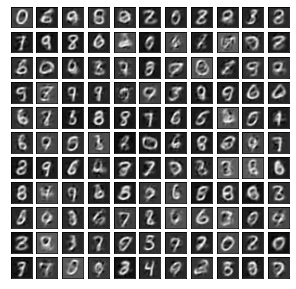

Epoch[90/100],recon_loss:9077.666016, kl_loss:2100.870117


 91%|█████████ | 91/100 [1:11:03<07:47, 51.91s/it]

Epoch[91/100],recon_loss:10028.310547, kl_loss:2047.643555


 92%|█████████▏| 92/100 [1:11:53<06:50, 51.33s/it]

Epoch[92/100],recon_loss:9726.896484, kl_loss:2043.505371


 93%|█████████▎| 93/100 [1:12:35<05:38, 48.41s/it]

Epoch[93/100],recon_loss:9428.674805, kl_loss:2052.773438


 94%|█████████▍| 94/100 [1:13:23<04:49, 48.32s/it]

Epoch[94/100],recon_loss:9605.946289, kl_loss:2070.377441


 95%|█████████▌| 95/100 [1:14:04<03:51, 46.27s/it]

Epoch[95/100],recon_loss:9020.074219, kl_loss:2108.186523


 96%|█████████▌| 96/100 [1:14:56<03:10, 47.73s/it]

Epoch[96/100],recon_loss:9260.688477, kl_loss:2063.665039


 97%|█████████▋| 97/100 [1:15:36<02:16, 45.53s/it]

Epoch[97/100],recon_loss:9081.921875, kl_loss:2087.964844


 98%|█████████▊| 98/100 [1:16:27<01:34, 47.15s/it]

Epoch[98/100],recon_loss:9960.636719, kl_loss:2082.855225


 99%|█████████▉| 99/100 [1:17:07<00:45, 45.14s/it]

Epoch[99/100],recon_loss:10223.108398, kl_loss:2069.630859


100%|██████████| 100/100 [1:18:02<00:00, 46.82s/it]


In [11]:
for epoch in tqdm(range(num_epoch)):
    AE.train()
    
    # epoch_loss = []
    # ========================= Sample and Visualization ====================
    if epoch % 10 == 0:
        VAE.eval()
        # sample z
        z = torch.randn(batch_size, 8).to(device)

        # sample x (i.e. imgs)
        sample = VAE.decoder(z)

        plt.close()
        grid_size, k = int(sample.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(sample[k].data.view(28,28).cpu().numpy(), cmap='gray')
            k += 1
        plt.show()
    # ========================= Training==========================================
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'
        # =============================== IMAGES =================================
        num_img = img.size(0)
        img = img.view(num_img, -1)
        img = img.to(device)
        # =============================== Compute Loss ===========================
        # Get output images, mean, std of encoded space
        reconst_img, mu, log_var = VAE(img)
        
        # l2 (mean squared error) loss.
        recon_loss = torch.sum((img - reconst_img) ** 2)
        
        # Kullback-Leibler divergence between encoded space and Gaussian
        kl_loss = KL_Divergence(mu, log_var)
        
        loss = recon_loss + kl_loss
        
        optimizer.zero_grad() # before back propagation
        loss.backward()
        optimizer.step()
        
        if (i+1)%250 == 0:
                print('Epoch[{}/{}],recon_loss:{:.6f}, kl_loss:{:.6f}'.format(
                    epoch,num_epoch,recon_loss.item(),kl_loss.item()))


# Visualization Phase
## Ex1: Sample image randomly
Generate images by sampling 
$$ z \sim p(z),\quad x \sim p(x|z,\theta) $$ 
PS: Just like we do in training phase per 10 epochs.

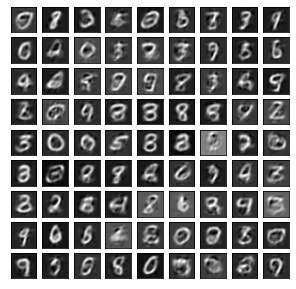

In [15]:
# sample z
z = torch.randn(batch_size, 8).to(device)

# sample x (i.e. imgs)
sample = VAE.decoder(z)

plt.close()
grid_size, k = int(reconst_img.shape[0] ** 0.5), 0 # 10 * 10
fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    ax[i,j].imshow(sample[k].data.view(28,28).cpu().numpy(), cmap='gray')
    k += 1
plt.show()

## Ex2: Sample Interpolated Images
sample two random latent vectors from $p(z)$,
        then sample from their interpolated values

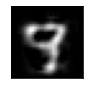

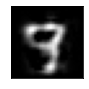

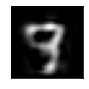

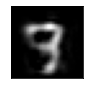

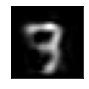

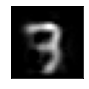

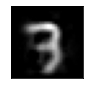

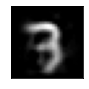

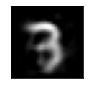

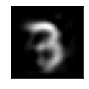

In [18]:
# Sample 2 latent vectors 
z1 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z2 = torch.normal(torch.zeros(8), 1)

# Interpolate within latent vectors

for alpha in np.linspace(0, 1, 10):
    z = (alpha * z1 + (1 - alpha) * z2).to(device)
    sample = VAE.decoder(z)
    img = to_gray_img(sample)
    plt.close()
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_axes([0,0,1,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img.data.view(28,28).cpu().numpy(), cmap = 'gray')
    plt.show()

## Ex3: Explore the latent space
Sample four random latent vectors from $p(z)$, then sample two of them as the x-axis, the other as y-axis.

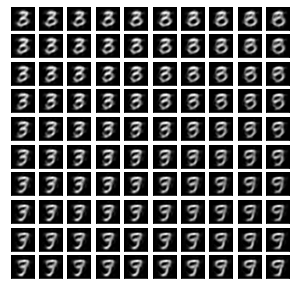

In [19]:
# Sample 2 latent vectors as X-axis 
z1 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z2 = torch.normal(torch.zeros(8), 1)

# Sample 2 latent vectors as Y-axis 
z3 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z4 = torch.normal(torch.zeros(8), 1)




i = 0
j = 0
plt.close()
fig, ax = plt.subplots(10, 10, figsize=(5, 5))

for alpha in np.linspace(0, 1, 10):
    j = 0
    for beta in np.linspace(0, 1, 10):
        z = ((alpha * z1 + (1 - alpha) * z2 + beta * z3 + (1 - beta) * z4)/2).to(device)
        sample = VAE.decoder(z)
        img = to_gray_img(sample)
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].imshow(img.data.view(28,28).cpu().numpy(), cmap='gray')
        j += 1
    i += 1
    
plt.show()